<a href="https://colab.research.google.com/github/Nicolas-Noir/AA2-TUIA-2025/blob/main/Practica/AA2_lab9_b_29_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 - Sentiment Analysis con RNNs

El objetivo de este laboratorio es entrenar un clasificador de reseñas de películas utilizando una red neuronal recurrente (RNN). Para ello, se utilizará el dataset de IMDB, que contiene 50,000 reseñas de películas etiquetadas como positivas o negativas.

## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

In [ ]:
import os

REPO_NAME = "lab9"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/FCEIA-AAII/{REPO_NAME}.git
  os.chdir(REPO_NAME)


Cloning into 'lab9'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 17), reused 15 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 36.73 KiB | 2.45 MiB/s, done.
Resolving deltas: 100% (17/17), done.


Importar librerías

In [ ]:
import numpy as np
from pathlib import Path
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Cargar dataset:

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.55M9H6_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.55M9H6_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.55M9H6_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Inspeccionar dataset:

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Vemos que el primer elemento es un tf.string, que contiene la reseña de la película. El segundo elemento es un tf.int64, que contiene la etiqueta de la reseña (0 para negativa, 1 para positiva).

Inspeccionamos algunos ejemplos:

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Shuffle y batching:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Mostrar un batch de ejemplos:

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I also saw this movie at a local screening about a year ago. First, I\'m going to say that it looks great. Cassella is incredibly talented and a fantastic cinematographer. I just wish the movie had been as good as it looks. I would not call this a horror movie. Putting in a few shots of a decaying ghost does not make it a horror movie. There\'s no mystery, there\'s no suspense, you know who did it the entire time. <br /><br />It\'s a drama. You know what\'s going on with both sides the entire movie. The acting was okay, I guess, but nothing special.<br /><br />And the tagline, "Revenge can be deadly"....really?...they should have check how many hundreds of horror/thriller movies have that exact same tagline?<br /><br />It pains me to say some of this, but I know a lot of the people who worked on this movie, and I know they don\'t want people blowing smoke up their ass, so I give my honest opinion.'
 b'I watched the Canadian videotape of this movie as "The Witching" which som

Creamos un tokenizador:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

only_text = train_dataset.map(lambda text, label: text)

# La función adapt ajusta el vocabulario al texto, debe ser llamada con un dataset de texto
encoder.adapt(only_text)

Mostramos los primeros 20 tokens:

Los dos primeros tokens son los de padding y desconocido, respectivamente. Los siguientes tokens son los más comunes en el dataset.

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Una vez que tenemos el tokenizador, podemos convertir las reseñas a tokens:

In [ ]:
encoded_example = encoder(example)[0].numpy()
encoded_example

array([ 10,  79, 208,  11,  18,  31,   4, 688,   1,  43,   4, 336, 598,
        86, 142, 166,   6, 130,  12,   9, 263,  85,   1,   7, 927,   1,
         3,   4, 765,   1,  10,  41, 624,   2,  18,  67,  75,  15,  50,
        15,   9, 263,  10,  59,  22, 658,  11,   4, 197,  18,   1,   8,
         4, 164, 640,   5,   4,   1,   1, 121,  22,  94,   9,   4, 197,
        18, 213,  57, 755, 213,  57, 866,  23, 118,  37, 117,   9,   2,
       417,  62,  13,  13,  30,   4, 477,  23, 118, 697, 166,  21,  17,
       191,   1,   2, 417,  18,   2, 112,  14, 869,  10, 479,  19, 158,
         1,  13,   3,   2,   1,   1,  69,  28,   1, 139,  26, 819,  87,
       106,   1,   5,   1,  93,  26,  12,   1, 167,   1,  13,   9,   1,
        70,   6, 130,  47,   5,  11,  19,  10, 118,   4, 169,   5,   2,
        83,  37, 926,  21,  11,  18,   3,  10, 118,  35,  90, 178,  83,
         1,   1,  58,  65,   1,  38,  10, 192,  56,   1, 656,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

Construimos el siguiente modelo:

![model.png](https://github.com/FCEIA-AAII/lab9/blob/main/model.png?raw=1)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Entrenamos

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.5450 - loss: 0.6922 - val_accuracy: 0.6335 - val_loss: 0.6772
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.7102 - loss: 0.5822 - val_accuracy: 0.8316 - val_loss: 0.3759
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.8468 - loss: 0.3630 - val_accuracy: 0.8508 - val_loss: 0.3464
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.8560 - loss: 0.3364 - val_accuracy: 0.8335 - val_loss: 0.3786
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.8594 - loss: 0.3300 - val_accuracy: 0.8632 - val_loss: 0.3281
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.8719 - loss: 0.3086 - val_accuracy: 0.8592 - val_loss: 0.3321
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - accuracy: 0.8731 - loss: 0.3068 - val_accuracy: 0.8639 - val_loss: 0.3222
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 630ms/step - accuracy: 0.8778 - loss: 0.2989 - val_accu

Definimos una función para plotear métricas:

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Evaluamos métricas:

98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8619 - loss: 0.3179
Test Loss: 0.31683602929115295
Test Accuracy: 0.8616799712181091


(0.0, 0.7097341567277908)

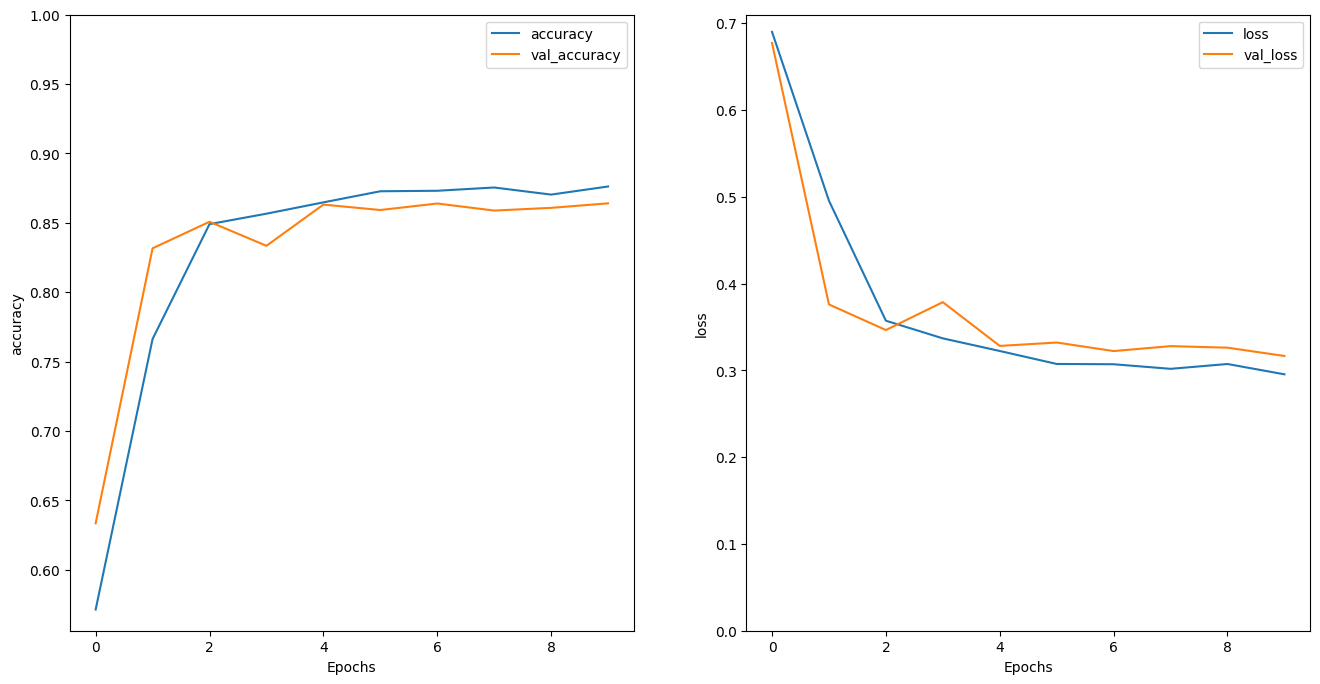

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Corremos sobre reseñas de ejemplo:

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))

print(sample_text)
print(predictions)

sample_text = ('An awful movie. A lackluster plot, uninspired performances, and forgettable action sequences.')
predictions = model.predict(tf.constant([sample_text]))

print(sample_text)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.
[[0.64712226]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
An awful movie. A lackluster plot, uninspired performances, and forgettable action sequences.
[[0.33898264]]


Probar agregando una segunda capa LSTM bidireccional, la primer capa debe devolver secuencias (argumento `return_sequences=True`).